In [1]:
import sys

import numpy as np

import tensorflow as tf
from keras.datasets import mnist

from PySide6.QtWidgets import QApplication
from PySide6.QtCore import QObject, Signal
from PySide6.QtCore import QThread

import matplotlib.pyplot as plt

from UI import PlotWindow

2024-02-21 17:56:29.780206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 17:56:29.780255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 17:56:29.781401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 17:56:29.788875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 17:56:30.714331: W tensorflow/compiler/tf2

Training class

In [2]:
class Worker(QObject):
    finished = Signal()
    update_plot = Signal(dict)

    def __init__(self, model, X_train, y_train, X_test, y_test):
        super().__init__()
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def train_model(self):
        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            batch_size=200,
            epochs=15,
            callbacks=[CallbackPlot(window)],
        )
        self.finished.emit()
        return history

Callback class, that updating plot every epoch with actual losses 

In [3]:
class CallbackPlot(tf.keras.callbacks.Callback):
    def __init__(self, window):
        super().__init__()
        self.window = window

    def on_epoch_end(self, epoch, logs=None):
        loss = logs['loss']
        val_loss = logs['val_loss']
        self.window.update_plot(loss, val_loss)

In [5]:
if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = PlotWindow()
    window.show()
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(kernel_size=3, filters=30, input_shape=(28, 28, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    worker = Worker(model, X_train, y_train, X_test, y_test)
    worker_thread = QThread()
    worker.moveToThread(worker_thread)
    worker.finished.connect(worker_thread.quit)
    worker_thread.started.connect(worker.train_model)
    worker_thread.start()
    
    sys.exit(app.exec())

RuntimeError: Please destroy the QApplication singleton before creating a new QApplication instance.

Test

In [9]:
image = tf.io.read_file('./test.png')
image = tf.io.decode_png(image, channels=1)  # Преобразование в черно-белое
image = tf.image.resize(image, (28, 28))     # Изменение размера

# Преобразование в массив numpy и добавление размера пакета
image = np.expand_dims(image, axis=0)

In [17]:
model(image)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.13688679e-04, 2.28274264e-03, 2.16965000e-05, 1.75189357e-02,
        2.14612828e-05, 8.80097225e-02, 3.42037878e-04, 7.89923608e-01,
        2.37179978e-04, 1.01528935e-01]], dtype=float32)>

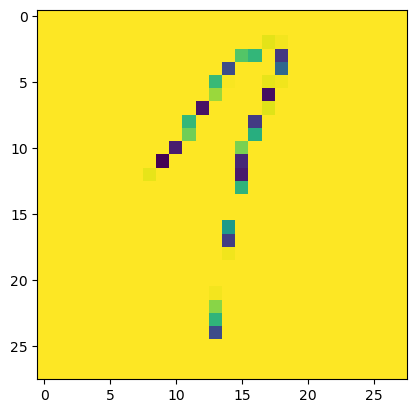

In [16]:
plt.imshow(image.squeeze())
plt.show()

NameError: name 'window' is not defined